In [10]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from utils import *
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [2]:
# transform = transforms.Compose([
#     transforms.Resize((128, 128)),  # Zmiana rozmiaru obrazów
#     transforms.ToTensor(),         # Konwersja do tensora
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalizacja
# ])

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

root_dir = 'root/celeba'

#ŁADOWANIE DANYCH==================================================================
train_dataset = CustomCelebA(root=root_dir, split="train", attr_index=31, transform=transform)
valid_dataset = CustomCelebA(root=root_dir, split="valid", attr_index=31, transform=transform)
test_dataset = CustomCelebA(root=root_dir, split="test", attr_index=31, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Chosen: Smiling
Total images in split 'train': 162770
Positive samples: 78080, Negative samples: 84690
Balanced dataset size: 156160
Chosen: Smiling
Total images in split 'valid': 19867
Positive samples: 9602, Negative samples: 10265
Balanced dataset size: 19204
Chosen: Smiling
Total images in split 'test': 19962
Positive samples: 9987, Negative samples: 9975
Balanced dataset size: 19950


Train Dataset:


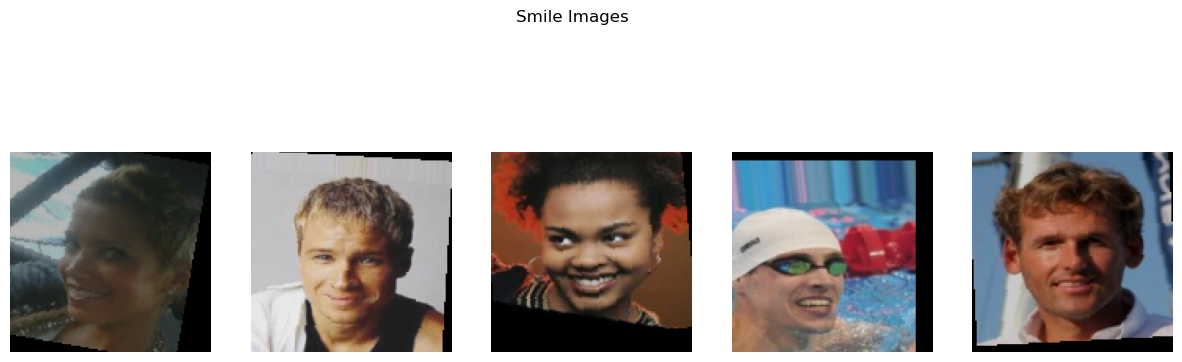

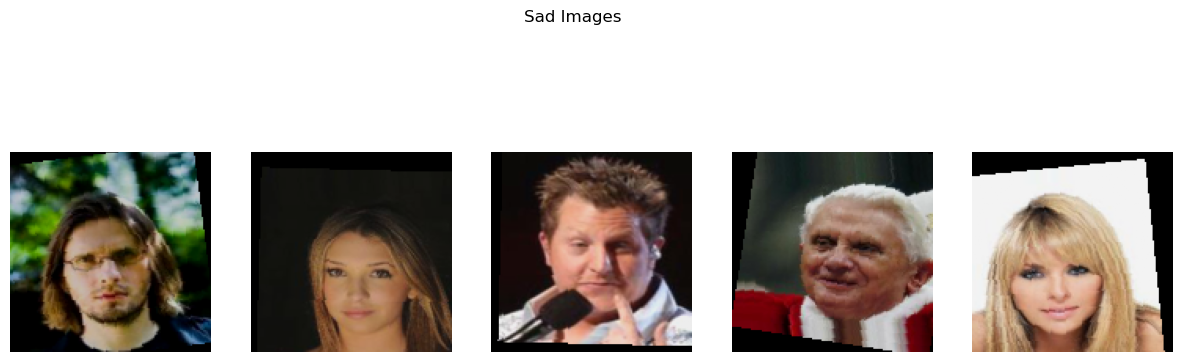

Validation Dataset:


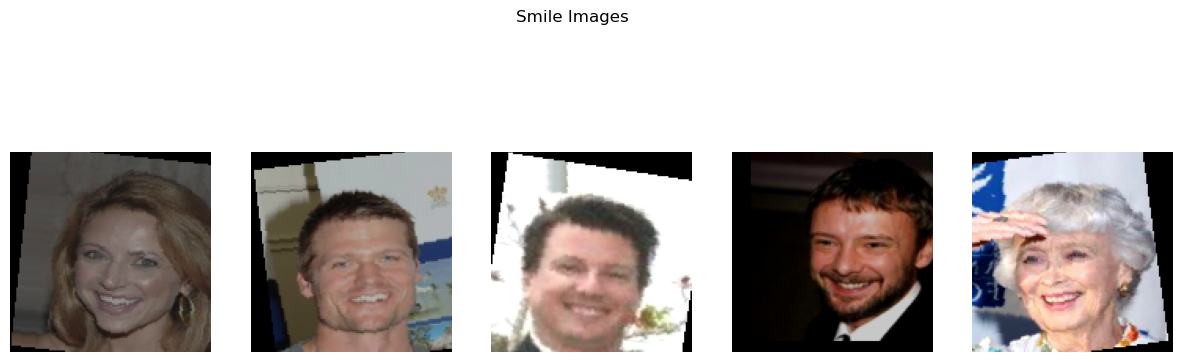

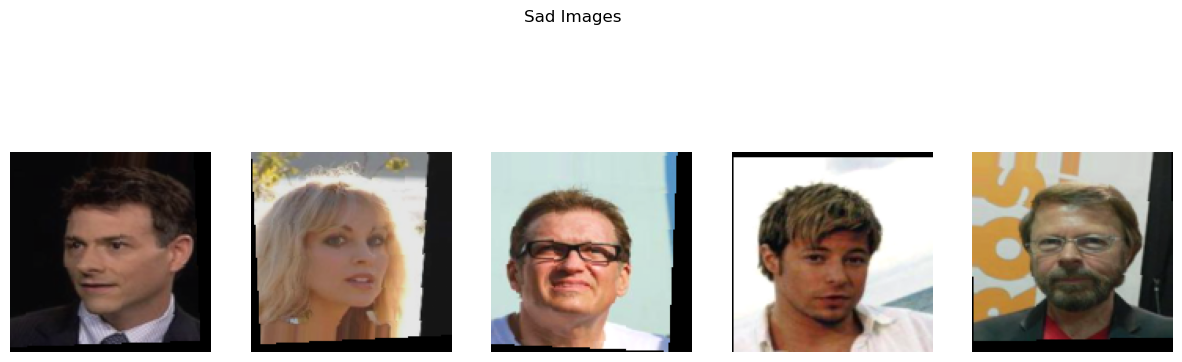

Test Dataset:


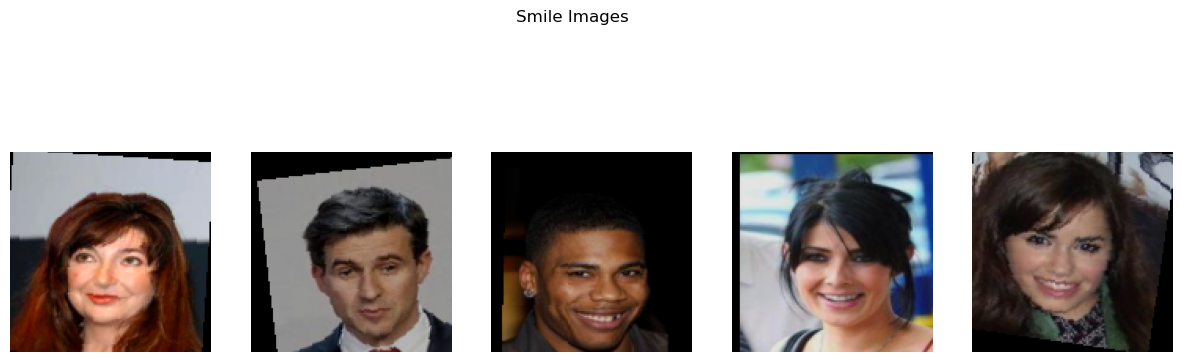

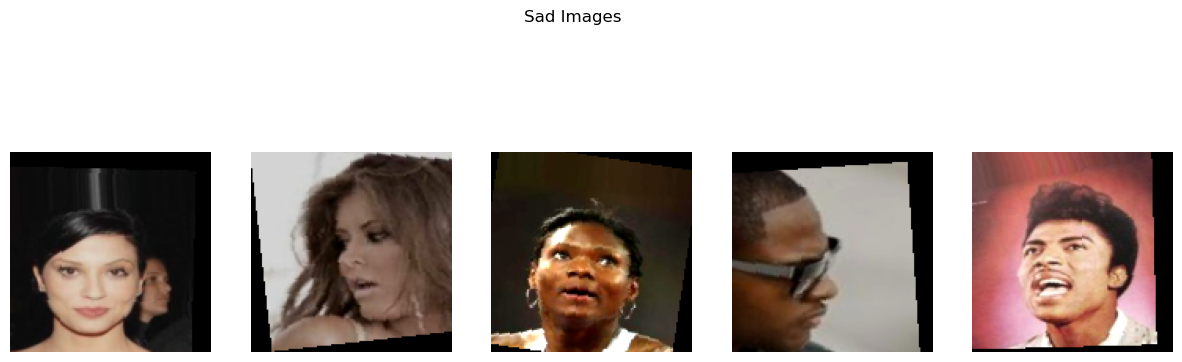

In [3]:
def show_samples_from_loader(loader, num_samples=5):
    smile_images = []
    sad_images = []

    # Iterate through the DataLoader
    for images, labels in loader:
        for img, label in zip(images, labels):
            if label == 1 and len(smile_images) < num_samples:
                smile_images.append(img)
            elif label == 0 and len(sad_images) < num_samples:
                sad_images.append(img)
            if len(smile_images) == num_samples and len(sad_images) == num_samples:
                break
        if len(smile_images) == num_samples and len(sad_images) == num_samples:
            break

    # Display male images
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    fig.suptitle("Smile Images")
    for i, img in enumerate(smile_images):
        img = img.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Denormalize
        img = img.clamp(0, 1)  # Clamp values to be in valid range
        axes[i].imshow(img)
        axes[i].axis("off")
    plt.show()

    # Display female images
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    fig.suptitle("Sad Images")
    for i, img in enumerate(sad_images):
        img = img.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Denormalize
        img = img.clamp(0, 1)  # Clamp values to be in valid range
        axes[i].imshow(img)
        axes[i].axis("off")
    plt.show()


# Show samples for each DataLoader
print("Train Dataset:")
show_samples_from_loader(train_loader)

print("Validation Dataset:")
show_samples_from_loader(valid_loader)

print("Test Dataset:")
show_samples_from_loader(test_loader)

In [4]:
#TRENOWANIE MODELU==================================================================
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Funkcja do trenowania
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(loader):
        images, labels = images.to(device), labels.to(device)
        # print(f"Images shape: {images.shape}, Labels shape: {labels.shape}")

        optimizer.zero_grad()
        outputs = model(images)
        # print(f"Outputs shape: {outputs.shape}, Labels shape: {labels.shape}")
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(loader)


def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return running_loss / len(loader), accuracy

Using device: mps


/Users/mateusz/anaconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [5]:
num_epochs = 25
train_losses = []
val_losses = []
val_accuracies = []

#EARLY STOPPING
early_stopping = EarlyStopping(patience=5, delta=0.01, path="test_smile.pth")

#KRENING ROBIE
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, valid_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
    
    # Adjust learning rate
    scheduler.step(val_loss)

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break


100%|██████████| 2440/2440 [07:49<00:00,  5.19it/s]


Epoch 1/25, Train Loss: 0.6970, Val Loss: 0.6932, Val Accuracy: 50.00%


100%|██████████| 2440/2440 [06:58<00:00,  5.83it/s]


Epoch 2/25, Train Loss: 0.6932, Val Loss: 0.6932, Val Accuracy: 50.00%


100%|██████████| 2440/2440 [05:52<00:00,  6.92it/s]


Epoch 3/25, Train Loss: 0.6601, Val Loss: 0.5662, Val Accuracy: 70.75%


100%|██████████| 2440/2440 [05:51<00:00,  6.95it/s]


Epoch 4/25, Train Loss: 0.3895, Val Loss: 0.3287, Val Accuracy: 86.03%


100%|██████████| 2440/2440 [05:52<00:00,  6.93it/s]


Epoch 5/25, Train Loss: 0.2999, Val Loss: 0.2797, Val Accuracy: 88.14%


100%|██████████| 2440/2440 [05:51<00:00,  6.94it/s]


Epoch 6/25, Train Loss: 0.2743, Val Loss: 0.2647, Val Accuracy: 88.59%


100%|██████████| 2440/2440 [05:51<00:00,  6.94it/s]


Epoch 7/25, Train Loss: 0.2609, Val Loss: 0.2608, Val Accuracy: 88.94%


100%|██████████| 2440/2440 [05:50<00:00,  6.95it/s]


Epoch 8/25, Train Loss: 0.2506, Val Loss: 0.2482, Val Accuracy: 89.82%


100%|██████████| 2440/2440 [05:55<00:00,  6.87it/s]


Epoch 9/25, Train Loss: 0.2450, Val Loss: 0.2433, Val Accuracy: 89.68%


100%|██████████| 2440/2440 [05:51<00:00,  6.94it/s]


Epoch 10/25, Train Loss: 0.2412, Val Loss: 0.2454, Val Accuracy: 89.56%


100%|██████████| 2440/2440 [05:56<00:00,  6.84it/s]


Epoch 11/25, Train Loss: 0.2378, Val Loss: 0.2338, Val Accuracy: 90.18%


100%|██████████| 2440/2440 [05:50<00:00,  6.96it/s]


Epoch 12/25, Train Loss: 0.2331, Val Loss: 0.2250, Val Accuracy: 90.49%


100%|██████████| 2440/2440 [05:49<00:00,  6.98it/s]


Epoch 13/25, Train Loss: 0.2310, Val Loss: 0.2272, Val Accuracy: 90.44%


100%|██████████| 2440/2440 [05:49<00:00,  6.97it/s]


Epoch 14/25, Train Loss: 0.2291, Val Loss: 0.2321, Val Accuracy: 90.20%


100%|██████████| 2440/2440 [05:48<00:00,  6.99it/s]


Epoch 15/25, Train Loss: 0.2274, Val Loss: 0.2245, Val Accuracy: 90.43%


100%|██████████| 2440/2440 [05:49<00:00,  6.98it/s]


Epoch 16/25, Train Loss: 0.2274, Val Loss: 0.2193, Val Accuracy: 90.62%


100%|██████████| 2440/2440 [05:48<00:00,  7.00it/s]


Epoch 17/25, Train Loss: 0.2237, Val Loss: 0.2281, Val Accuracy: 90.50%


100%|██████████| 2440/2440 [05:49<00:00,  6.99it/s]


Epoch 18/25, Train Loss: 0.2215, Val Loss: 0.2164, Val Accuracy: 90.98%


100%|██████████| 2440/2440 [05:48<00:00,  7.01it/s]


Epoch 19/25, Train Loss: 0.2220, Val Loss: 0.2162, Val Accuracy: 91.12%


100%|██████████| 2440/2440 [05:55<00:00,  6.86it/s]


Epoch 20/25, Train Loss: 0.2218, Val Loss: 0.2305, Val Accuracy: 90.28%


100%|██████████| 2440/2440 [05:51<00:00,  6.93it/s]


Epoch 21/25, Train Loss: 0.2202, Val Loss: 0.2233, Val Accuracy: 90.71%
Early stopping triggered!


In [6]:
#TESTOWANKO
model.load_state_dict(torch.load("test_smile.pth"))
test_loss, test_accuracy = validate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

/var/folders/q7/wxqvnl3j4zv3s1b841gddlvr0000gn/T/ipykernel_14108/2647171697.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("test_smile.

Test Loss: 0.2246, Test Accuracy: 90.66%


In [7]:
#WIDERFACE

import pandas as pd
from pathlib import Path
from PIL import Image
from torchvision import models

def test_custom_images_with_csv(model, image_dir, csv_file, transform, device):
    model.eval()
    correct = 0
    total = 0

    # Load CSV with image names and labels
    labels_df = pd.read_csv(csv_file)

    with torch.no_grad():
        for _, row in labels_df.iterrows():
            img_name = row['image']
            label = 1 if row['label'] == 'smiling' else 0

            # print(f'Image_name: {img_name} - {label}')

            img_path = Path(image_dir) / img_name

            if not img_path.exists():
                print(f"Image not found: {img_path}")
                continue

            # Load and preprocess image
            image = Image.open(img_path).convert("RGB")
            image = transform(image).unsqueeze(0).to(device)
            label = torch.tensor([label]).to(device)

            # Model prediction
            outputs = model(image)
            _, predicted = torch.max(outputs, 1)

            # Compare prediction with the true label
            total += 1
            correct += (predicted == label).sum().item()

    accuracy = 100 * correct / total
    print(f"Custom Dataset Accuracy: {accuracy:.2f}%")
    return accuracy

# ŚCIEŻKA DO DANYCH TESTOWYCH
custom_image_dir = "WIDER_FACE/extracted"
csv_file_path = "WIDER_FACE/extracted/labels2.csv"
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
model.load_state_dict(torch.load("test_smile.pth"))

# TESTOWANIE NA WŁASNYCH ZDJĘCIACH Z CSV
test_custom_images_with_csv(model, custom_image_dir, csv_file_path, transform, device)


/var/folders/q7/wxqvnl3j4zv3s1b841gddlvr0000gn/T/ipykernel_14108/3928454355.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("test_smile

Custom Dataset Accuracy: 78.00%


78.0

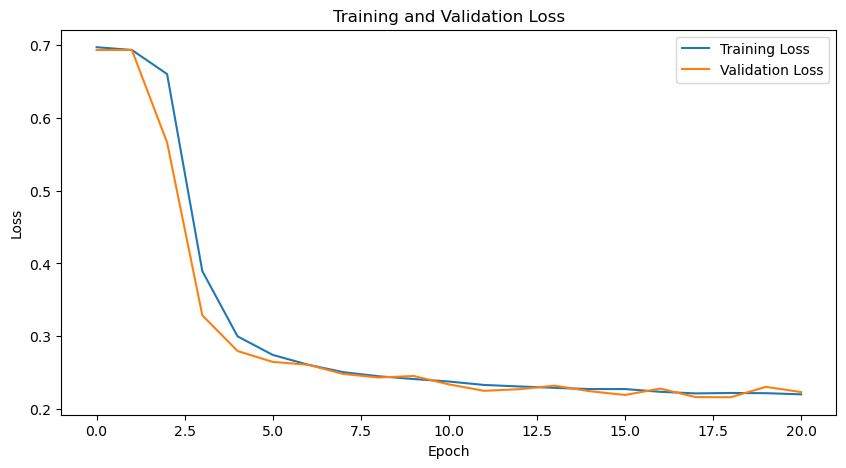

[0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 

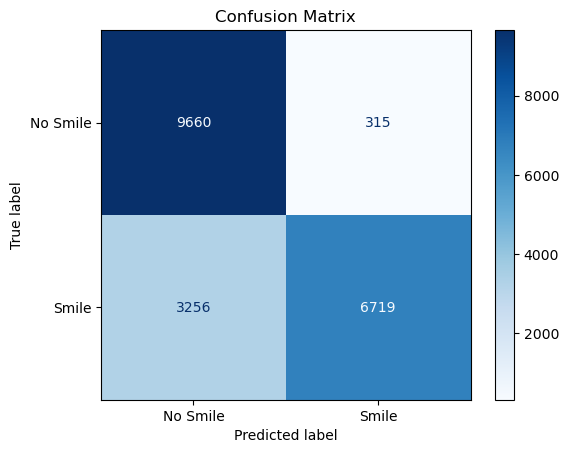

In [16]:
# WYKRESY ========================================================================
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

# Confusion Matrix
model.eval()
def plot_confusion_matrix(loader, device):
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            predictions = (outputs > 0.5).float().cpu().numpy()
            predictions = np.argmax(predictions, axis=1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions)

    cm = confusion_matrix(all_labels, all_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Smile", "Smile"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

plot_loss(train_losses, val_losses)
plot_confusion_matrix(test_loader, device)
